In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

In [3]:
# Check the head of each dataset to ensure they're loaded correctly
print("Customers DataFrame:\n", customers_df.head())
print("\nTransactions DataFrame:\n", transactions_df.head())

Customers DataFrame:
   CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transactions DataFrame:
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [4]:
#Data Cleaning & Basic Preprocessing / Joining Data
# Convert date columns to datetime --
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

# -- Merge customers with their transactions on CustomerID --

merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')

agg_data = merged_df.groupby('CustomerID').agg({
    'TransactionID': 'count',            # transaction frequency
    'Quantity': 'sum',                   # total quantity purchased
    'TotalValue': 'sum',                 # total spent
    'TransactionDate': 'max',            # for recency calculation
    'SignupDate': 'max',                 # to help with tenure
    'Region': 'first'                    # region from the first profile row
}).reset_index()

agg_data = agg_data.rename(columns={
    'TransactionID': 'NumTransactions',
    'Quantity': 'TotalQuantity',
    'TotalValue': 'TotalSpent',
    'TransactionDate': 'LastTransactionDate'
})

# Compute average order value
agg_data['AvgOrderValue'] = agg_data['TotalSpent'] / agg_data['NumTransactions']

# Compute Recency: e.g., days from last transaction to a reference date
#   Let's choose today's date or max transaction date as a reference
reference_date = merged_df['TransactionDate'].max()  # or datetime.now()
agg_data['RecencyDays'] = (reference_date - agg_data['LastTransactionDate']).dt.days

# Compute Tenure in days since signup (from the reference date)
agg_data['TenureDays'] = (reference_date - agg_data['SignupDate']).dt.days

# Now we have a summary dataframe with each row = 1 customer
print("\nAggregated Features for Each Customer:\n", agg_data.head())



Aggregated Features for Each Customer:
   CustomerID  NumTransactions  TotalQuantity  TotalSpent LastTransactionDate  \
0      C0001                5             12     3354.52 2024-11-02 17:04:16   
1      C0002                4             10     1862.74 2024-12-03 01:41:41   
2      C0003                4             14     2725.38 2024-08-24 18:54:04   
3      C0004                8             23     5354.88 2024-12-23 14:13:52   
4      C0005                3              7     2034.24 2024-11-04 00:30:22   

  SignupDate         Region  AvgOrderValue  RecencyDays  TenureDays  
0 2022-07-10  South America        670.904           55         902  
1 2022-02-13           Asia        465.685           25        1049  
2 2024-03-07  South America        681.345          125         296  
3 2022-10-09  South America        669.360            4         811  
4 2022-08-15           Asia        678.080           54         866  


# **Feature Engineering**

In [6]:
onehot = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore') # Replace sparse with sparse_output
region_oh = onehot.fit_transform(agg_data[['Region']])

# Extract the new one-hot-encoded column names
region_categories = onehot.get_feature_names_out(['Region'])

# Make a new DataFrame for the encoded region columns
region_df = pd.DataFrame(region_oh, columns=region_categories)

# Combine with the original agg_data
agg_data.reset_index(drop=True, inplace=True)
region_df.reset_index(drop=True, inplace=True)
agg_data_oh = pd.concat([agg_data, region_df], axis=1)

# Drop the original 'Region' column if you no longer need it
agg_data_oh.drop(columns='Region', inplace=True)

# 6. Select Final Features

feature_columns = [
    'NumTransactions',
    'TotalQuantity',
    'TotalSpent',
    'AvgOrderValue',
    'RecencyDays',
    'TenureDays'
] + list(region_categories)  # add the OHE region columns

X = agg_data_oh[feature_columns].copy()

# Clean any possible inf or NaN values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# 7. Data Scaling

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 8. Clustering (K-Means Example) & Choose Best # of Clusters

dbi_scores = []
sil_scores = []
K_values = range(2, 11)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    db_index = davies_bouldin_score(X_scaled, labels)
    dbi_scores.append(db_index)

    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

    print(f"K={k} -> Davies-Bouldin Index: {db_index:.4f}, Silhouette Score: {sil:.4f}")

optimal_k = K_values[np.argmin(dbi_scores)]
print(f"\nOptimal K based on lowest DBI: {optimal_k}")

# 9. Final Model with Optimal K & Assign Clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = kmeans_final.fit_predict(X_scaled)

# Attach cluster labels back to agg_data_oh
agg_data_oh['Cluster'] = final_labels

# Print cluster counts
print("\nCluster Counts:\n", agg_data_oh['Cluster'].value_counts())

final_db_index = davies_bouldin_score(X_scaled, final_labels)
print(f"\nFinal DB Index (K={optimal_k}): {final_db_index:.4f}")

K=2 -> Davies-Bouldin Index: 1.7762, Silhouette Score: 0.1893
K=3 -> Davies-Bouldin Index: 1.6754, Silhouette Score: 0.1673
K=4 -> Davies-Bouldin Index: 1.5804, Silhouette Score: 0.2079
K=5 -> Davies-Bouldin Index: 1.5290, Silhouette Score: 0.2292
K=6 -> Davies-Bouldin Index: 1.4126, Silhouette Score: 0.2322
K=7 -> Davies-Bouldin Index: 1.4142, Silhouette Score: 0.2277
K=8 -> Davies-Bouldin Index: 1.3553, Silhouette Score: 0.2434
K=9 -> Davies-Bouldin Index: 1.3832, Silhouette Score: 0.2314
K=10 -> Davies-Bouldin Index: 1.4330, Silhouette Score: 0.2152

Optimal K based on lowest DBI: 8

Cluster Counts:
 Cluster
4    36
5    32
3    27
1    25
2    25
0    22
7    21
6    11
Name: count, dtype: int64

Final DB Index (K=8): 1.3553


# **Elbow Method for Number of clusters**

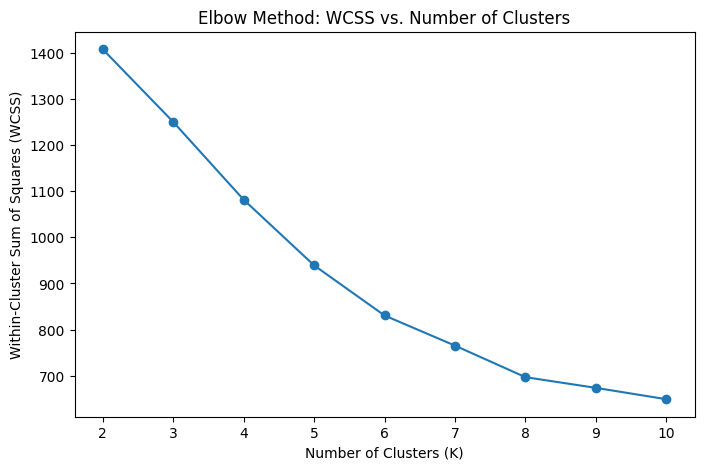

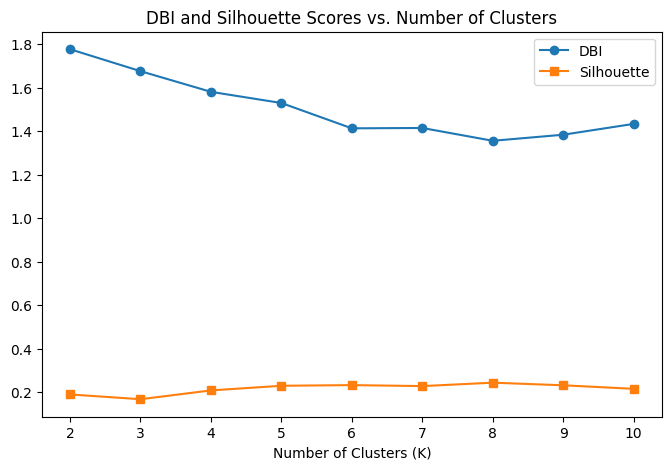

In [7]:
# Range of possible clusters
K_values = range(2, 11)

wcss = []  # Within-Cluster Sum of Squares
dbi_scores = []  # Davies-Bouldin Index (optional to compare with elbow)
sil_scores = []  # Silhouette Score (also optional)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)

    # 2a. WCSS (inertia)
    wcss.append(kmeans.inertia_)

    # 2b. DBI
    labels = kmeans.labels_
    db_index = davies_bouldin_score(X_scaled, labels)
    dbi_scores.append(db_index)

    # 2c. Silhouette
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

#Plot the Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(K_values, wcss, marker='o')
plt.title('Elbow Method: WCSS vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K_values)
plt.show()

# plot DBI or Silhouette to cross-check
plt.figure(figsize=(8,5))
plt.plot(K_values, dbi_scores, marker='o', label='DBI')
plt.plot(K_values, sil_scores, marker='s', label='Silhouette')
plt.title('DBI and Silhouette Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.legend()
plt.show()

# **Plot of Clusters using PCA**

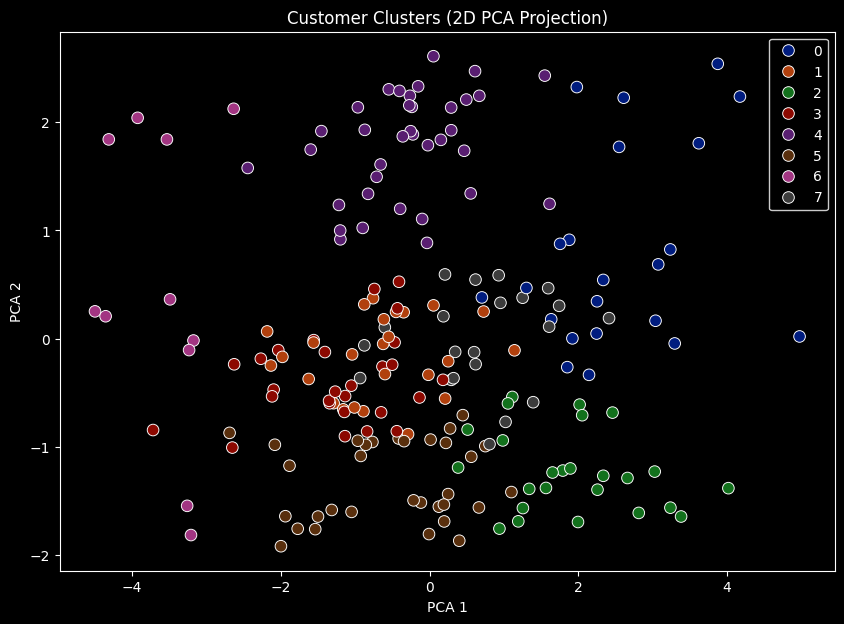

In [9]:
from sklearn.decomposition import PCA
# Perform PCA with 2 components
pca_2d = PCA(n_components=2)
pca_result = pca_2d.fit_transform(X_scaled)

# Store PCA coordinates for plotting
agg_data_oh['pca1'] = pca_result[:, 0]
agg_data_oh['pca2'] = pca_result[:, 1]

# Set a dark theme for the plot
plt.style.use('dark_background')
plt.figure(figsize=(10, 7))

# Use a darker color palette
sns.scatterplot(
    x='pca1', y='pca2',
    hue='Cluster',
    data=agg_data_oh,
    palette='dark',
    s=70  # Adjust point size for better visibility
)

plt.title("Customer Clusters (2D PCA Projection)", color='white')
plt.xlabel("PCA 1", color='white')
plt.ylabel("PCA 2", color='white')
plt.legend(facecolor='black', edgecolor='white')  # Dark legend background
plt.show()
